# AIPI 590 - XAI | Assignment #06

### Yiqing Liu
### Description
This notebook implements a simple adversarial patch attack against a pretrained ResNet-34 on ImageNet. We optimize a small patch so that, when pasted onto images, the model predicts the target class (ImageNet index 388: giant panda).


In [1]:
#The above code snippet was generated using Claude 4.5 Sonnet on 2/11/25 at 00:15 am.
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import random
import time

# --- Config ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TARGET_CLASS = 388  # ImageNet index for 'giant_panda'
PATCH_SIZE = 50     # Patch size (50x50 pixels)
BATCH_SIZE = 64
EPOCHS = 10         # Number of epochs to optimize the patch
LR = 0.01           # Learning rate

print(f"--- Adversarial Patch Attack ---")
print(f"Device: {DEVICE}")
print(f"Target: Class {TARGET_CLASS} (Giant Panda)")
print(f"Patch size: {PATCH_SIZE}x{PATCH_SIZE}")
print(f"--------------------------------")


--- Adversarial Patch Attack ---
Device: cuda
Target: Class 388 (Giant Panda)
Patch size: 50x50
--------------------------------


### Data and Preprocessing

In [2]:
# Data transforms: keep pixel values in [0,1] before patching
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # -> [0, 1]
])

# ImageNet normalization (must be applied AFTER patching)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Load STL10 as background images
train_dataset = datasets.STL10(root='./data', split='train', download=True, transform=data_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

print(f"Loaded background dataset: {len(train_dataset)} images.")


100%|██████████| 2.64G/2.64G [02:33<00:00, 17.2MB/s]


Loaded background dataset: 5000 images.


### Model
Next, we load a pretrained ResNet-34 (ImageNet1K_V1) and freeze all its parameters. Only the patch tensor will be optimized.


In [3]:
# Load pretrained model
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
model = model.to(DEVICE)
model.eval()  # evaluation mode

# Freeze all model parameters
for param in model.parameters():
    param.requires_grad = False

print("ResNet-34 loaded and frozen.")


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 236MB/s]


ResNet-34 loaded and frozen.


### Patch Initialization

We initialize the patch and uses function `apply_random_patch` pastes the patch at a random location on each image in the batch.


In [4]:
def apply_random_patch(images, patch):
    """
    Paste the patch at a random location on each image in the batch.

    Args:
        images (Tensor): [B, C, H, W], values in [0, 1]
        patch (Tensor): [C, P, P], values in [0, 1]

    Returns:
        Tensor: Patched images [B, C, H, W]
    """
    patched_images = images.clone()
    for i in range(patched_images.size(0)):
        img_h, img_w = patched_images.size(2), patched_images.size(3)
        x_start = random.randint(0, img_w - PATCH_SIZE)
        y_start = random.randint(0, img_h - PATCH_SIZE)
        patched_images[i, :, y_start:y_start+PATCH_SIZE, x_start:x_start+PATCH_SIZE] = patch
    return patched_images

# Initialize the patch (learnable)
patch = torch.rand(3, PATCH_SIZE, PATCH_SIZE, device=DEVICE, requires_grad=True)

# Optimizer updates only the patch
optimizer = optim.Adam([patch], lr=LR)
criterion = nn.CrossEntropyLoss()


### Optimization

We optimize the patch by maximizing the model's confidence for the target class on patched images.

In [5]:
for epoch in range(EPOCHS):
    start_time = time.time()
    total_loss = 0.0
    success_count = 0
    total_count = 0

    for images, _ in train_loader:  # labels are not needed
        images = images.to(DEVICE)

        # 1) Apply the patch at random locations
        patched_images = apply_random_patch(images, patch)

        # 2) Normalize for the model
        normalized_images = normalize(patched_images)

        # 3) Forward pass
        outputs = model(normalized_images)

        # 4) Target labels: force the model to predict the target class
        target_labels = torch.full((images.size(0),), TARGET_CLASS, dtype=torch.long, device=DEVICE)

        # 5) Loss
        loss = criterion(outputs, target_labels)

        # 6) Backward (only the patch gets gradients)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 7) Keep patch in [0,1]
        with torch.no_grad():
            patch.clamp_(0, 1)

        total_loss += loss.item()

        # Track "success" rate within the batch
        preds = torch.argmax(outputs, dim=1)
        success_count += (preds == TARGET_CLASS).sum().item()
        total_count += images.size(0)

    avg_loss = total_loss / len(train_loader)
    success_rate = 100.0 * success_count / total_count
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1}/{EPOCHS} | Time: {epoch_time:.2f}s | Loss: {avg_loss:.4f} | Attack success: {success_rate:.2f}%")

print("Patch optimization complete.")


Epoch 1/10 | Time: 6.29s | Loss: 9.5024 | Attack success: 0.20%
Epoch 2/10 | Time: 4.36s | Loss: 3.2581 | Attack success: 36.44%
Epoch 3/10 | Time: 4.26s | Loss: 0.7115 | Attack success: 83.80%
Epoch 4/10 | Time: 4.28s | Loss: 0.3857 | Attack success: 90.68%
Epoch 5/10 | Time: 4.30s | Loss: 0.2890 | Attack success: 92.78%
Epoch 6/10 | Time: 4.25s | Loss: 0.2350 | Attack success: 94.26%
Epoch 7/10 | Time: 5.03s | Loss: 0.2141 | Attack success: 94.64%
Epoch 8/10 | Time: 4.44s | Loss: 0.1911 | Attack success: 95.82%
Epoch 9/10 | Time: 4.50s | Loss: 0.1876 | Attack success: 95.44%
Epoch 10/10 | Time: 4.37s | Loss: 0.1681 | Attack success: 95.92%
Patch optimization complete.


### Save and Evaluate

Finally, we save the learned patch and evaluate it by placing it at the image center. We compare predictions before and after patching and compute the final success rate.


In [6]:
# Save the learned patch and run a final evaluation on a held-out batch

torchvision.utils.save_image(patch, 'panda_patch.png')
print("Saved patch to 'panda_patch.png'")

# Grab a batch for testing
test_images, _ = next(iter(train_loader))
test_images = test_images.to(DEVICE)

# A) Original predictions
with torch.no_grad():
    original_outputs = model(normalize(test_images))
    original_preds = torch.argmax(original_outputs, dim=1)
print("Original preds (first 10):", original_preds.cpu().numpy()[:10])

# B) Center-patched predictions
patched_images = test_images.clone()
x_start = (224 - PATCH_SIZE) // 2
y_start = (224 - PATCH_SIZE) // 2
patched_images[:, :, y_start:y_start+PATCH_SIZE, x_start:x_start+PATCH_SIZE] = patch

with torch.no_grad():
    patched_outputs = model(normalize(patched_images))
    patched_preds = torch.argmax(patched_outputs, dim=1)
print("Patched preds (first 10):", patched_preds.cpu().numpy()[:10])

# C) Final success rate
final_success_rate = (patched_preds == TARGET_CLASS).float().mean().item()
print(f"\nFinal center-patch attack success rate: {final_success_rate * 100:.2f}% (target index: {TARGET_CLASS})")


Saved patch to 'panda_patch.png'
Original preds (first 10): [351 867 404 867 163 817 436 867 353 817]
Patched preds (first 10): [388 388 388 388 388 388 388 388 388 388]

Final center-patch attack success rate: 98.44% (target index: 388)


### Visualization

We visualize a batch of original images and their center-patched versions side by side, and report top-1 predictions (index) and average target-class confidence.


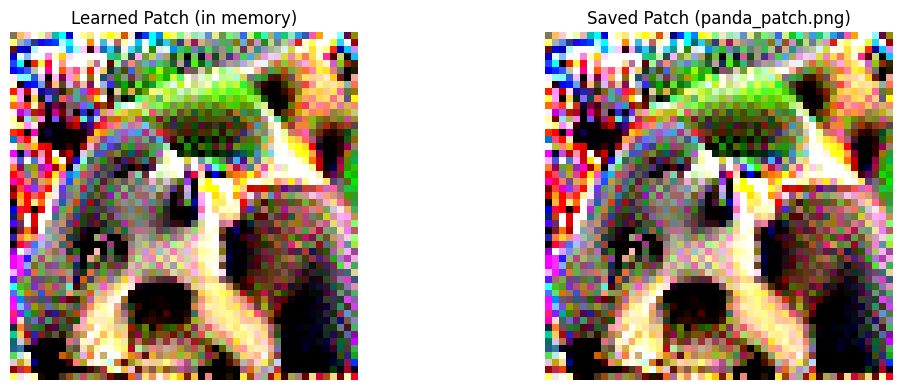

In [10]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Helper to convert tensor patch to numpy image
def _to_np_img(t):
    t = t.detach().clamp(0,1).cpu().permute(1,2,0).numpy()
    return t

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 1) In-memory learned patch
axes[0].imshow(_to_np_img(patch))
axes[0].set_title('Learned Patch (in memory)')
axes[0].axis('off')

# 2) Saved patch file if exists
saved_path = 'panda_patch.png'
if os.path.exists(saved_path):
    axes[1].imshow(np.asarray(Image.open(saved_path).convert('RGB')))
    axes[1].set_title('Saved Patch (panda_patch.png)')
else:
    axes[1].text(0.5, 0.5, 'panda_patch.png not found', ha='center', va='center')
    axes[1].set_title('Saved Patch')
axes[1].axis('off')

plt.tight_layout()
plt.show()


Avg target prob BEFORE: 0.000
Avg target prob AFTER : 0.982


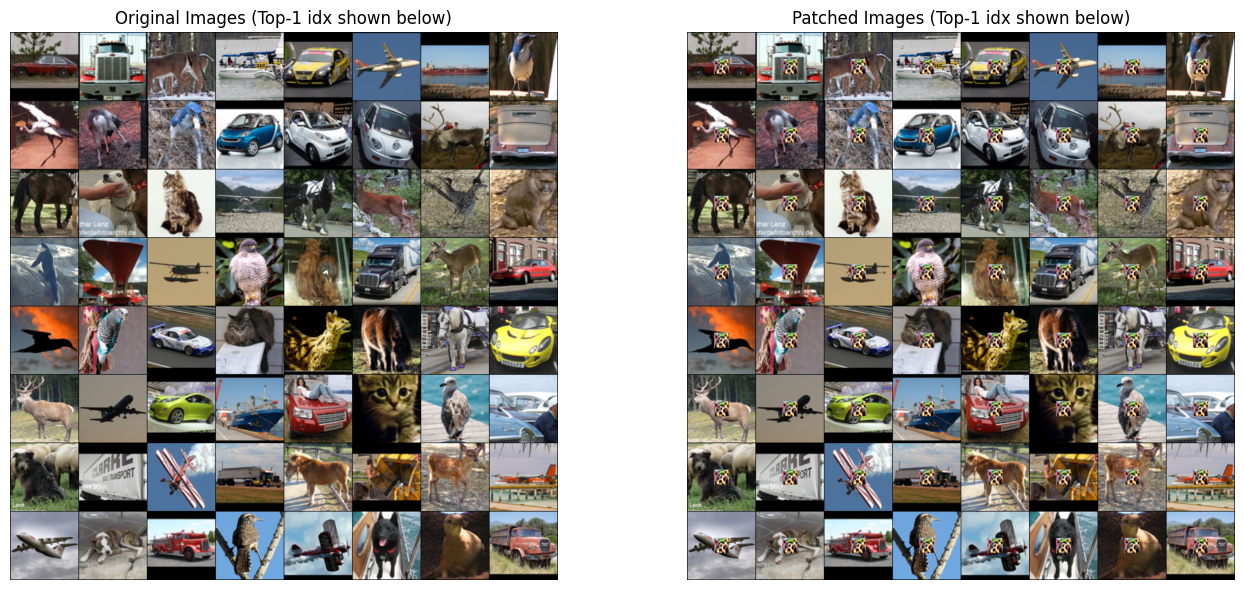

Top-1 indices BEFORE (first 16): [817, 867, 167, 484, 817, 404, 510, 17, 128, 9, 17, 656, 817, 817, 349, 511]
Top-1 indices AFTER  (first 16): [388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388]


In [8]:
import matplotlib.pyplot as plt
import torchvision

# Fetch a batch
vis_images, _ = next(iter(train_loader))
vis_images = vis_images.to(DEVICE)

# Original predictions
with torch.no_grad():
    logits_orig = model(normalize(vis_images))
    probs_orig = logits_orig.softmax(dim=1)
    preds_orig = probs_orig.argmax(dim=1)

# Center patch the batch
vis_patched = vis_images.clone()
x0 = (224 - PATCH_SIZE) // 2
y0 = (224 - PATCH_SIZE) // 2
vis_patched[:, :, y0:y0+PATCH_SIZE, x0:x0+PATCH_SIZE] = patch

# Patched predictions
with torch.no_grad():
    logits_pat = model(normalize(vis_patched))
    probs_pat = logits_pat.softmax(dim=1)
    preds_pat = probs_pat.argmax(dim=1)

# Compute average target probability
avg_target_prob_before = probs_orig[:, TARGET_CLASS].mean().item()
avg_target_prob_after = probs_pat[:, TARGET_CLASS].mean().item()
print(f"Avg target prob BEFORE: {avg_target_prob_before:.3f}")
print(f"Avg target prob AFTER : {avg_target_prob_after:.3f}")

# Make grids for visualization
grid_orig = torchvision.utils.make_grid(vis_images.cpu(), nrow=8)
grid_pat = torchvision.utils.make_grid(vis_patched.cpu(), nrow=8)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(grid_orig.permute(1, 2, 0).clamp(0,1))
axes[0].set_title('Original Images (Top-1 idx shown below)')
axes[0].axis('off')
axes[1].imshow(grid_pat.permute(1, 2, 0).clamp(0,1))
axes[1].set_title('Patched Images (Top-1 idx shown below)')
axes[1].axis('off')
plt.tight_layout()
plt.show()

# Print first 16 indices before/after for quick comparison
print('Top-1 indices BEFORE (first 16):', preds_orig[:16].cpu().tolist())
print('Top-1 indices AFTER  (first 16):', preds_pat[:16].cpu().tolist())


# References

- Brown, T. B., Mané, D., Roy, A., Abadi, M., & Gilmer, J. (2017). *Adversarial Patch*. NeurIPS 2017. arXiv:1712.09665.  
  PDF: https://arxiv.org/pdf/1712.09665.

- AIPI-590 XAI: *Adversarial patches* example notebook (Duke-AI-XAI).  
  GitHub notebook: https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/adversarial-ai-example-notebooks/adversarial_attacks_patches.ipynb.
